In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, f1_score,accuracy_score ,precision_recall_curve, average_precision_score
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import os
import pickle
from torchvision import transforms
import pytorch_lightning as pl
import torch

# load own code
import sys
sys.path.append('../')
from sleeplib.Resnet_15.model import ResNet
from sleeplib.datasets import BonoboDataset, ContinousToSnippetDataset
# this holds all the configuration parameters
from sleeplib.config import Config
import pickle

from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
from torchvision import transforms

from sleeplib.datasets import BonoboDataset , ContinousToSnippetDataset
from sleeplib.montages import CDAC_bipolar_montage,CDAC_common_average_montage,CDAC_combine_montage,con_combine_montage
from sleeplib.transforms import cut_and_jitter, channel_flip, extremes_remover


In [127]:
path_model = 'your_path/SpikeNet2/Models/spikenet2/'
# load config file
config = Config()
config.print_config()

# load dataset
df = pd.read_csv('your_path.csv',sep=',') # ; -> ,

# fraction filter
frac_filter = (df['fraction_of_yes'] >= 6/8) | (df['fraction_of_yes'] <= 2/8)
spike_filter = df['fraction_of_yes'] >= 6/8
mode_filter = df['Mode'] == 'Test'
extreme_quality_filter = df['total_votes_received'] >= 8
quality_filter = df['total_votes_received'] >= 2

test_df = df[mode_filter]
AUC_df = df[extreme_quality_filter & mode_filter & frac_filter]
spike_df = df[extreme_quality_filter & mode_filter & spike_filter]
print(f'there are {len(AUC_df)} test samples')

print(f'there are {len(spike_df)} spike')
# set up dataloader to predict all samples in test dataset
transform_val = transforms.Compose([cut_and_jitter(windowsize=config.WINDOWSIZE,max_offset=0,Fq=config.FQ),
                                    extremes_remover(signal_max = 2000, signal_min = 20)])#,CDAC_signal_flip(p=0)])
combine_montage = CDAC_combine_montage()

test_dataset = BonoboDataset(test_df, 'your_path', 
                           transform = transform_val,
                           window_size = config.WINDOWSIZE,
                           montage = combine_montage
                          )
test_dataloader = DataLoader(test_dataset, batch_size=32,shuffle=False,num_workers=os.cpu_count())
for x, y in test_dataloader:
    with torch.no_grad():
        print(x.shape)
        break


THIS CONFIG FILE CONTAINS THE FOLLOWING PARAMETERS :

PATH_FILES_BONOBO /data/0shared/lijun/data/bonobo/npy_1
PATH_LUT_BONOBO /data/0shared/lijun/code/Spike_37chan/hard_mining.csv
PATH_CONTINOUS_EEG /data/0shared/eeg/bonobo/continuousEEG
FQ 128
MONTAGE bipolar
WINDOWSIZE 1
N_FFT 128
HOP_LENGTH 64
HEAD_DROPOUT 0.3
EMB_SIZE 256
HEADS 8
DEPTH 4
N_CHANNELS 37
BATCH_SIZE 256
LR 0.0001
there are 1258 test samples
there are 924 spike
torch.Size([32, 37, 128])


In [128]:
# load pretrained model
model = ResNet.load_from_checkpoint('your_path/SpikeNet2/Models/spikenet2/your.ckpt',
                                        lr=config.LR,
                                        n_channels=config.N_CHANNELS
                                       )
                                        #map_location=torch.device('cpu') add this if running on CPU machine
# init trainer
trainer = pl.Trainer(devices=1, accelerator="gpu",fast_dev_run=False,enable_progress_bar=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [129]:
# predict all samples
preds = trainer.predict(model,test_dataloader)
preds = np.concatenate(preds)
# store results
results = test_df[['event_file','fraction_of_yes','total_votes_received','Mode']].copy()
results['preds'] = preds

results.to_csv(path_model+'/predictions.csv',index=False)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


In [130]:
path_model = 'your_path/SpikeNet2/Models/spikenet2/'
df = pd.read_csv(path_model+'predictions.csv')

# set up filters for datasets
high_quality_filter = df['total_votes_received']>=2
ultra_quality_filter = df['total_votes_received']>=8
mode_filter = df['Mode']=='Test'
frac_filter = (df['fraction_of_yes'] >=6/8) | (df['fraction_of_yes'] <= 2/8)

# load samples as defined in spikenet paper
AUC_df = df[ultra_quality_filter & mode_filter & frac_filter]

labels = AUC_df.fraction_of_yes.values.round(0).astype(int)

preds = AUC_df.preds
# calculate ROC and AUC
fpr, tpr, thresholds = roc_curve(labels, preds)
roc_auc = auc(fpr, tpr)

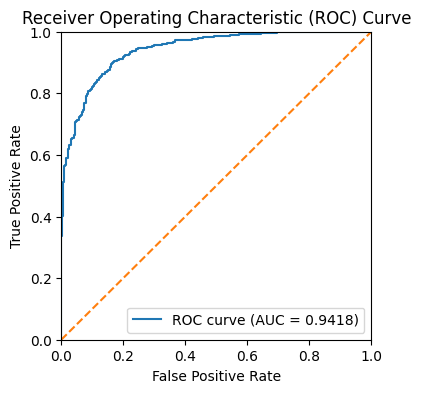

In [131]:
# plot ROC 
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(fpr, tpr, label='ROC curve (AUC = %0.4f)' % roc_auc)
ax.plot([0, 1], [0, 1], linestyle='--')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curve')
ax.legend()
fig.savefig(path_model+'ROC.png', dpi=300, bbox_inches='tight')

